<a href="https://colab.research.google.com/github/SapirBashan/radar_animation/blob/main/radar_simulation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp
from scipy.fftpack import fft, fftshift
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D

# Radar parameters
c = 3e8  # Speed of light
f0 = 24e9  # Start frequency (24 GHz)
B = 200e6  # Bandwidth
T = 1e-3  # Chirp duration
fs = 1e6  # Sampling frequency

num_range_gates = 100
num_pri = 256
num_channels = 4
num_beams = 8
pulse_repetition_frequency = 1000  # Hz

# Target parameters
R = 100  # Range (m)
v = 10  # Velocity (m/s)

# Time array
t = np.arange(0, T, 1/fs)

def simulate_radar_data():
    data = np.zeros((num_range_gates, num_pri, num_channels), dtype=complex)
    tx_signal = chirp(t, f0, T, f0 + B, method='linear')
    tau = 2 * R / c  # Time delay
    fd = 2 * v * f0 / c  # Doppler shift
    rx_signal = chirp(t - tau, f0, T, f0 + B, method='linear') * np.exp(1j * 2 * np.pi * fd * t)

    for ch in range(num_channels):
        for pri in range(num_pri):
            random_delay = np.random.normal(0, 1e-6)
            random_doppler = np.random.normal(0, 1)
            rx_signal_with_noise = chirp(t - (tau + random_delay), f0, T, f0 + B, method='linear') * \
                                   np.exp(1j * 2 * np.pi * (fd + random_doppler) * t)
            mixed_signal = tx_signal * rx_signal_with_noise.conj()
            data[:, pri, ch] = mixed_signal[:num_range_gates]

    return data

def mti_filter(data):
    return np.diff(data, axis=1)

def doppler_processing(data):
    return fftshift(fft(data, axis=1), axes=1)

def cfar(data, guard_cells=2, reference_cells=4):
    threshold = np.zeros_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            start = max(0, j - reference_cells - guard_cells)
            end = min(data.shape[1], j + reference_cells + guard_cells + 1)
            window = np.concatenate((data[i, start:j-guard_cells],
                                      data[i, j+guard_cells+1:end]))
            threshold[i, j] = np.mean(window) * 2
    return data > threshold

def calculate_power(data):
    return np.abs(data)**2

def plot_3d_stage(data, title, frame_idx):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    ax.plot_surface(X, Y, np.abs(data[:, :, 0]), cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('PRI')
    ax.set_ylabel('Range Gate')
    ax.set_zlabel('Amplitude')
    frame_path = f"frame_{frame_idx:02d}.png"
    plt.savefig(frame_path)
    plt.close()
    return frame_path

def plot_2d_stage(data, title, frame_idx, x_label):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.plot(np.abs(data[0, :]))
    plt.xlabel(x_label)
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.tight_layout()
    frame_path = f"frame_{frame_idx:02d}.png"
    plt.savefig(frame_path)
    plt.close()
    return frame_path

def radar_processing_pipeline():
    frames = []
    input_data = simulate_radar_data()
    frames.append(plot_3d_stage(input_data, "Stage 1: Input Signal (3D)", 1))

    channel_data = input_data[:, :, 0]
    frames.append(plot_2d_stage(channel_data, "Stage 2: Single Channel Data", 2, "Time (s)"))

    mti_data = mti_filter(channel_data)
    frames.append(plot_2d_stage(mti_data, "Stage 3: After MTI Filter", 3, "Time (s)"))

    doppler_data = doppler_processing(mti_data)
    frames.append(plot_2d_stage(doppler_data, "Stage 4: After FFT", 4, "Frequency (Hz)"))

    cfar_data = cfar(np.abs(doppler_data))
    frames.append(plot_2d_stage(cfar_data, "Stage 5: After CFAR", 5, "Frequency (Hz)"))

    power_data = calculate_power(doppler_data)
    frames.append(plot_2d_stage(power_data, "Stage 6: Power Calculation", 6, "Frequency (Hz)"))

    final_output = np.stack([power_data for _ in range(num_beams)], axis=-1)
    frames.append(plot_2d_stage(final_output[:, :, 0], "Stage 7: Final Output", 7, "Frequency (Hz)"))

    # Create GIF
    images = [Image.open(frame) for frame in frames]
    images[0].save("radar_processing.gif", save_all=True, append_images=images[1:], duration=1000, loop=0)
    print("GIF saved as 'radar_processing.gif'. Check the directory!")

# Run the pipeline
radar_processing_pipeline()


GIF saved as 'radar_processing.gif'. Check the directory!


In [6]:
!pip install filterpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=7482e1f0e130dadcb50ffc29a091fd7b20ec897b206aa943bd2bf5b7f9c23a84
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


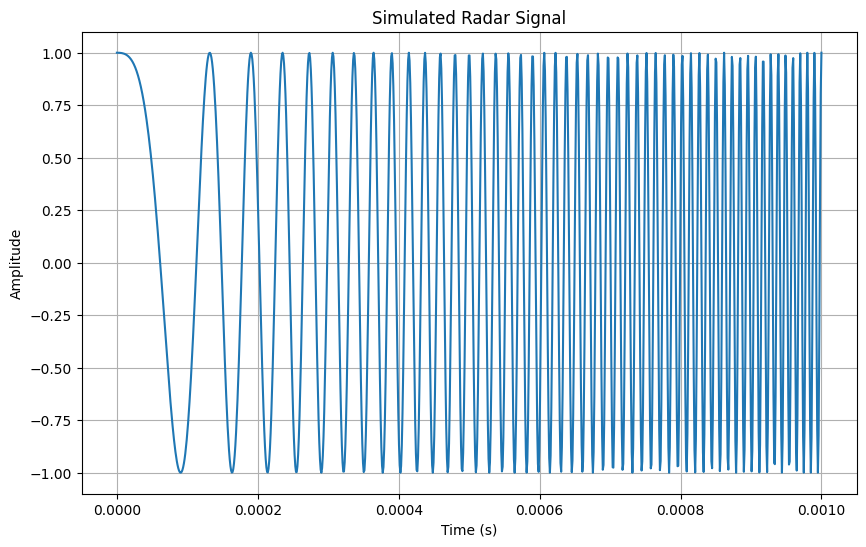

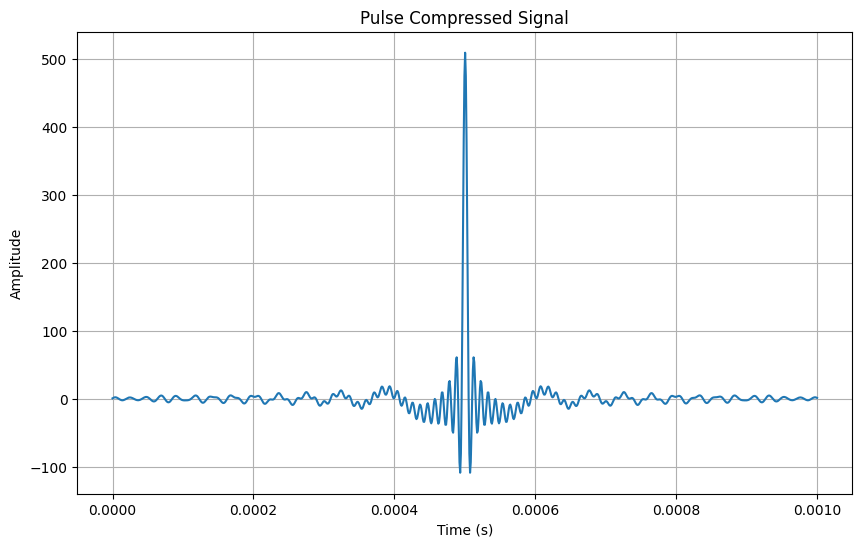

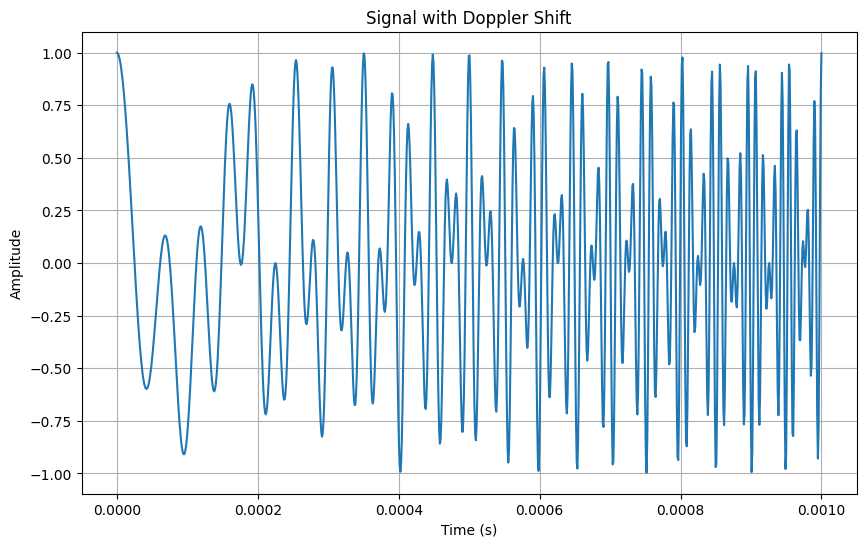

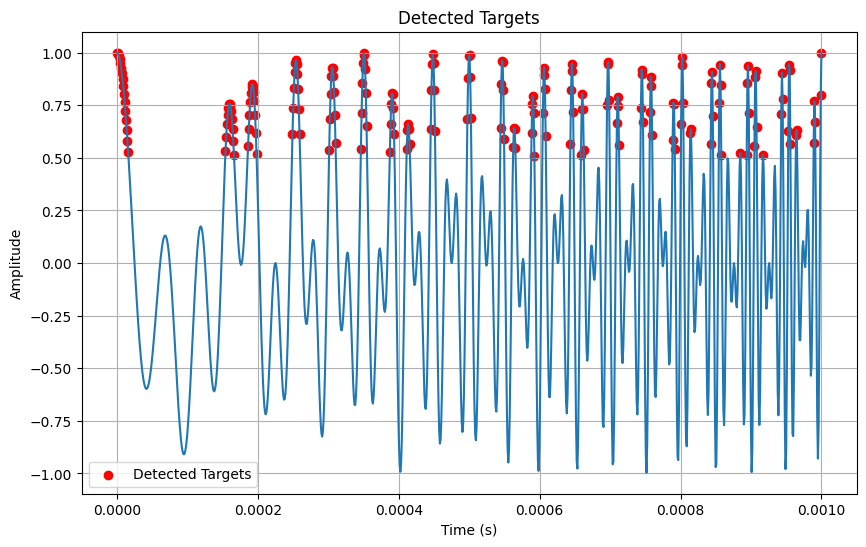

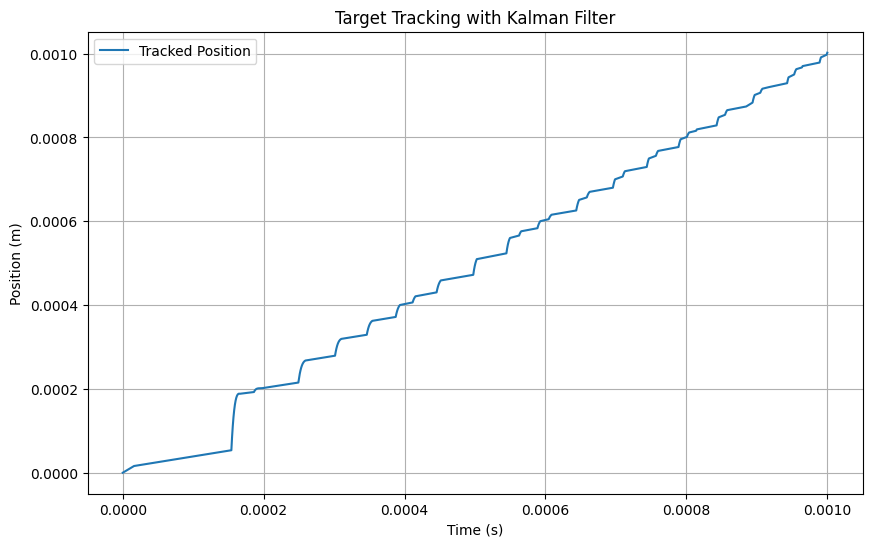

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from filterpy.kalman import KalmanFilter

# 1. Signal Generation (Simulated Radar Signal)
def generate_radar_signal(duration=1e-3, fs=1e6, f0=1e9, bandwidth=1e8):
    t = np.linspace(0, duration, int(fs * duration))
    chirp_signal = np.cos(2 * np.pi * (f0 + (bandwidth / 2) * t) * t)  # Frequency modulated signal
    return t, chirp_signal

# 2. Pulse Compression (Matched Filter)
def pulse_compression(signal, template):
    return correlate(signal, template, mode='same')

# 3. Doppler Shift Compensation
def apply_doppler_shift(signal, doppler_shift=1e4, fs=1e6):
    t = np.arange(len(signal)) / fs
    shift_signal = signal * np.exp(1j * 2 * np.pi * doppler_shift * t)
    return np.real(shift_signal)

# 4. Detection (Simple Thresholding)
def detect_targets(signal, threshold=0.5):
    return np.where(signal > threshold)[0]

# 5. Target Tracking (Using Kalman Filter)
def kalman_tracking(detected_positions):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([detected_positions[0], 0])  # initial state (position, velocity)
    kf.P *= 1000  # initial uncertainty
    kf.F = np.array([[1, 1], [0, 1]])  # state transition matrix
    kf.H = np.array([[1, 0]])  # observation matrix
    kf.R = 5  # measurement noise
    kf.Q = np.array([[0.01, 0], [0, 0.01]])  # process noise

    positions = []
    for z in detected_positions:
        kf.predict()
        kf.update(z)
        positions.append(kf.x[0])
    return np.array(positions)

# 6. Plotting each step
def plot_step(t, signal, title="Radar Signal"):
    plt.figure(figsize=(10, 6))
    plt.plot(t, signal)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

# Simulate radar process
t, signal = generate_radar_signal()

# Plot the original signal
plot_step(t, signal, "Simulated Radar Signal")

# Apply pulse compression
compressed_signal = pulse_compression(signal, signal)
plot_step(t, compressed_signal, "Pulse Compressed Signal")

# Apply Doppler shift (simulate target movement)
shifted_signal = apply_doppler_shift(signal)
plot_step(t, shifted_signal, "Signal with Doppler Shift")

# Detect targets (simple thresholding)
detected_positions = detect_targets(shifted_signal)
plt.figure(figsize=(10, 6))
plt.plot(t, shifted_signal)
plt.scatter(t[detected_positions], shifted_signal[detected_positions], color='red', label="Detected Targets")
plt.title("Detected Targets")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Track the targets using Kalman filter
tracked_positions = kalman_tracking(t[detected_positions])
plt.figure(figsize=(10, 6))
plt.plot(t[detected_positions], tracked_positions, label="Tracked Position")
plt.title("Target Tracking with Kalman Filter")
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

